# Projeto Base de Dados Avaliação de Imóveis

Por SEFMG

Data: 2018

In [1]:
import pandas as pd
import json
from timeit import default_timer as timer
import numpy as np
import requests
import re
import os

## Juntando informação

In [24]:
# lER ARQUIVO DA CIDADE DE CONSELHEIRO LAFAIETE e armazenar em Pandas DataFrame

xlsx = pd.ExcelFile('IPTU_Conselheiro_lafaiete.xlsx')

df_iptu_Conselheiro_lafaiete = pd.read_excel(xlsx, 'Conselheiro_lafaiete')

In [2]:
# lER ARQUIVO HISTORICO SEF e armazenar em Pandas DataFrame

xlsx = pd.ExcelFile('Historico_SEF3.xlsx')

df_Historico_SEF = pd.read_excel(xlsx, 'Historico_SEF')

In [4]:
# Exibindo as 5 primeiras linhas da tabela
df_iptu_Conselheiro_lafaiete.head(5)

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano
0,910112,53.8,136.46,23251.78,ap,DIAS DE SOUZA,15,CENTRO,NaN,* AP 4,NaN,CONSELHEIRO LAFAIETE,2017
1,81736,600,0,686.88,NaN,4,NaN,.,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017
2,82422,600,0,1707.56,NaN,7,NaN,JARDIM EUROPA,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017
3,928585,150,48,6318.66,NaN,JUCA BARBEIRO,152,PAULO VI,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017
4,830909,0,26,1308.81,NaN,CARLOS AMORIM,561,SANTA MATILDE,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017


In [3]:
# Exibindo as 5 primeiras linhas da tabela
df_Historico_SEF.head(5)

,NR_PROT_DECLARACAO,INDICE_CADASTRAL,AREA_TERRENO,AREA_CONSTRUIDA,ESPECIE,CEP,CIDADE,TP_LOGRADOURO,LOGRADOURO,NUMERO,BAIRRO,SEF,DATA,COMPLEMENTO1
0,201103423329,4250360160077,800.0,68.20,AP,31030220.0,BELO HORIZONTE,RUA,GENOVEVA DE SOUZA,531,SAGRADA FAMILIA,131967.00,2011,106
1,201300510407,500171002A0159,489.0,78.42,AP,30421185.0,BELO HORIZONTE,RUA,OLINDA,544,NOVA SUISSA,58226.86,2010,302
2,201302531487,307005A0020332,2046.0,94.74,AP,31330670.0,BELO HORIZONTE,RUA,PROFESSOR DOMICIO MURTA,390,OURO PRETO,236544.78,2012,804
3,201403207881,106001B0012555,1618.5,56.00,AP,31015172.0,BELO HORIZONTE,RUA,CURVELO,132,FLORESTA,211405.82,2013,1.114 BLOCO B
4,201405062509,1131740050326,1169.4,167.67,AP,30320080.0,BELO HORIZONTE,RUA,PATAGONIA,379,SION,508710.78,2014,803


## Avaliação de dados

Depois de coletar cada um dos dados acima, avaliar visualmente e programaticamente em busca de problemas de qualidade e limpeza. 

In [5]:
# Informações da tabela
df_iptu_Conselheiro_lafaiete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65534 entries, 0 to 65533
Data columns (total 13 columns):
Indice_cadastral    65533 non-null object
Area_terreno        64706 non-null object
Area_construcao     64706 non-null object
IPTU                65533 non-null float64
Especie             5424 non-null object
Logradouro          65533 non-null object
Numero              48811 non-null object
Bairro              65530 non-null object
CEP                 0 non-null float64
Complemento         15004 non-null object
Andar               0 non-null float64
Cidade              65534 non-null object
Ano                 65534 non-null int64
dtypes: float64(3), int64(1), object(9)
memory usage: 6.5+ MB


In [6]:
# Ver estatisticas do DataFrame dos valores nulos
df_iptu_Conselheiro_lafaiete.isnull().sum()

Indice_cadastral        1
Area_terreno          828
Area_construcao       828
IPTU                    1
Especie             60110
Logradouro              1
Numero              16723
Bairro                  4
CEP                 65534
Complemento         50530
Andar               65534
Cidade                  0
Ano                     0
dtype: int64

In [7]:
# verificando a linha do Indice_cadastral que esta nula
df_iptu_Conselheiro_lafaiete[df_iptu_Conselheiro_lafaiete['Indice_cadastral'].isnull()].head()

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano
56148,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017


In [8]:
# ver os 5 ultimos registros do DataFrame
df_iptu_Conselheiro_lafaiete.tail()

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano
65529,1160900,NaN,NaN,0.00,NaN,1,NaN,PARQUE QUINTAS DO IMPERAD,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017
65530,1148400,360,0,2844.00,NaN,1,0,JARDIM DOS CRISTAIS,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017
65531,1132999,324,0,3203.02,NaN,11,0,SAO LUCAS,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017
65532,1137577,332.1,0,3283.10,NaN,ADEMAR LIU DIAS DA SILVA,0,SAO LUCAS,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017
65533,1116333,420,0,9692.65,NaN,ALLEX MILAGRE,0,OURO VERDE,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017


In [9]:
# Ver estatisticas do DataFrame
df_iptu_Conselheiro_lafaiete.describe()

,IPTU,CEP,Andar,Ano
count,6.553300e+04,0.0,0.0,65534.0
mean,2.025049e+04,NaN,NaN,2017.0
std,2.418869e+05,NaN,NaN,0.0
min,0.000000e+00,NaN,NaN,2017.0
25%,3.694340e+03,NaN,NaN,2017.0
50%,8.954080e+03,NaN,NaN,2017.0
75%,1.819964e+04,NaN,NaN,2017.0
max,3.852403e+07,NaN,NaN,2017.0


In [10]:
# Ordenar os dados da coluna 'Bairro' em ordem alfabetica
df_iptu_Conselheiro_lafaiete.Bairro.sort_values()

46011              .
17259              .
57042              .
54296              .
53833              .
64793              .
10640              .
21647              .
54342              .
54789              .
5189               .
2511               .
51150              .
1                  .
2297               .
4925               .
356                .
732       AGUA PRETA
54011      ALBERTINA
19589      ALBERTINA
40723      ALBERTINA
15166      ALBERTINA
44349      ALBERTINA
60327      ALBERTINA
61193      ALBERTINA
12723      ALBERTINA
50147      ALBERTINA
25958      ALBERTINA
44370      ALBERTINA
56058      ALBERTINA
            ...     
44690    VILA VENEZA
13212    VILA VENEZA
44689    VILA VENEZA
13219    VILA VENEZA
20369    VILA VENEZA
24436    VILA VENEZA
61977    VILA VENEZA
51354    VILA VENEZA
19640    VILA VENEZA
19643    VILA VENEZA
64968    VILA VENEZA
42291    VILA VENEZA
45590    VILA VENEZA
45591    VILA VENEZA
42310    VILA VENEZA
64961    VILA VENEZA
16945    VILA

In [11]:
# verificando a linha do Bairro que esta nula
df_iptu_Conselheiro_lafaiete[df_iptu_Conselheiro_lafaiete['Bairro'].isnull()].head()

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano
11554,250724,69.12,122.1,22158.47,ap,JOSE CONDE DE LIMA,25,NaN,NaN,0APTｺ 704,NaN,CONSELHEIRO LAFAIETE,2017
29676,1165133,NaN,NaN,0.00,NaN,FELICIANO JOSE DA COSTA,1,NaN,NaN,5SALA 402,NaN,CONSELHEIRO LAFAIETE,2017
56148,NaN,NaN,NaN,0.00,NaN,NaN,0,NaN,NaN,NaN,NaN,CONSELHEIRO LAFAIETE,2017
63236,1160200,NaN,NaN,0.00,NaN,JOSE DE ALMEIDA PINTO,6,NaN,NaN,5A,NaN,CONSELHEIRO LAFAIETE,2017


In [12]:
# Ver o numero de entradas da coluna 'Bairro'
df_iptu_Conselheiro_lafaiete.Bairro.value_counts()

SAO JOAO                     4485
CENTRO                       4411
SANTA MATILDE                3736
RESIDENCIAL LIMA DIAS        2103
SAO SEBASTIAO                2074
CARIJOS                      1934
SAO DIMAS                    1767
SAG. CORACAO DE JESUS        1650
CACHOEIRA                    1581
PAULO VI                     1513
CAMPO ALEGRE                 1336
PROGRESSO                    1224
MOINHOS                      1159
RESIDENCIAL SION             1100
QUELUZ                       1053
ARCADIA                      1022
ROCHEDO                      1011
AMARO RIBEIRO                 987
VILA RESENDE                  956
MUSEU                         955
CHAPADA                       949
GIGANTE                       856
FONTE GRANDE                  854
JARDIM AMERICA                852
SANTO ANTONIO                 839
ALBINOPOLIS                   833
MORADA DO SOL                 833
SAO JUDAS TADEU               775
PANORAMA                      761
MANOEL DE PAUL

In [28]:
# Verificando registros do 'Area_terreno' que contem espaços em branco
df_iptu_Conselheiro_lafaiete[df_iptu_Conselheiro_lafaiete['Area_terreno'].str.contains("", na=False)].head()

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano
53266,52047,4.72 1,84.11 2,NaN,ap,ARMANDO ALVES DE OLIVEIRA,90,PARQUE BANDEIRANTES,NaN,APTｺ 302-BL.04,NaN,CONSELHEIRO LAFAIETE,2017


In [29]:
# Verificando registros do 'Area_construcao' que contem espaços em branco
df_iptu_Conselheiro_lafaiete[df_iptu_Conselheiro_lafaiete['Area_construcao'].str.contains("", na=False)].head()

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano
53266,52047,4.72 1,84.11 2,NaN,ap,ARMANDO ALVES DE OLIVEIRA,90,PARQUE BANDEIRANTES,NaN,APTｺ 302-BL.04,NaN,CONSELHEIRO LAFAIETE,2017


In [13]:
# Verificando registros do 'Complemento' que contem a palavra 'Ap'
df_iptu_Conselheiro_lafaiete.loc[df_iptu_Conselheiro_lafaiete['Complemento'].str.contains("Ap|AP|ap", na=False)].head()

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano
0,910112,53.8,136.46,23251.78,ap,DIAS DE SOUZA,15,CENTRO,NaN,* AP 4,NaN,CONSELHEIRO LAFAIETE,2017
42,1125033,13.93,49.46,5598.23,ap,AUGUSTO GETULIO VIEIRA,649,SAO DIMAS,NaN,* 1ｺPAV - APTｺ 101,NaN,CONSELHEIRO LAFAIETE,2017
64,1127199,54.76,205.2,39442.63,ap,AUGUSTO GETULIO VIEIRA,649,SAO DIMAS,NaN,* 2ｺPAV- APTｺ 201,NaN,CONSELHEIRO LAFAIETE,2017
66,1067125,275,0,3666.01,ap,PROFESSOR MANOEL LINO,519,MUSEU,NaN,* 2ｰPAV - APTｺ 01,NaN,CONSELHEIRO LAFAIETE,2017
67,1156933,NaN,NaN,0.00,ap,JOSE ANTONIO BELCHIOR,51,LOURDES,NaN,* A - APTｺ 02,NaN,CONSELHEIRO LAFAIETE,2017


In [4]:
# Informações da tabela
df_Historico_SEF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788850 entries, 0 to 788849
Data columns (total 14 columns):
NR_PROT_DECLARACAO    788850 non-null int64
INDICE_CADASTRAL      516409 non-null object
AREA_TERRENO          788835 non-null float64
AREA_CONSTRUIDA       788835 non-null float64
ESPECIE               247757 non-null object
CEP                   737446 non-null float64
CIDADE                737446 non-null object
TP_LOGRADOURO         737446 non-null object
LOGRADOURO            737446 non-null object
NUMERO                641436 non-null object
BAIRRO                737433 non-null object
SEF                   788738 non-null float64
DATA                  788850 non-null int64
COMPLEMENTO1          56084 non-null object
dtypes: float64(4), int64(2), object(8)
memory usage: 84.3+ MB


In [5]:
# Informações da tabela
df_Historico_SEF

,NR_PROT_DECLARACAO,INDICE_CADASTRAL,AREA_TERRENO,AREA_CONSTRUIDA,ESPECIE,CEP,CIDADE,TP_LOGRADOURO,LOGRADOURO,NUMERO,BAIRRO,SEF,DATA,COMPLEMENTO1
0,201103423329,4250360160077,800.00,68.20,AP,31030220.0,BELO HORIZONTE,RUA,GENOVEVA DE SOUZA,531,SAGRADA FAMILIA,131967.00,2011,106
1,201300510407,500171002A0159,489.00,78.42,AP,30421185.0,BELO HORIZONTE,RUA,OLINDA,544,NOVA SUISSA,58226.86,2010,302
2,201302531487,307005A0020332,2046.00,94.74,AP,31330670.0,BELO HORIZONTE,RUA,PROFESSOR DOMICIO MURTA,390,OURO PRETO,236544.78,2012,804
3,201403207881,106001B0012555,1618.50,56.00,AP,31015172.0,BELO HORIZONTE,RUA,CURVELO,132,FLORESTA,211405.82,2013,1.114 BLOCO B
4,201405062509,1131740050326,1169.40,167.67,AP,30320080.0,BELO HORIZONTE,RUA,PATAGONIA,379,SION,508710.78,2014,803
5,201502055434,NaN,998.82,154.86,AP,30130160.0,BELO HORIZONTE,RUA,ALAGOAS,335,FUNCIONARIOS,733618.94,2014,1402
6,201504607992,NaN,132.50,64.80,AP,36893000.0,MIRADOURO,RUA,Antônio Gomes Martins,31,Centro,44296.00,2015,101
7,201304419160,0140080070120,600.00,119.00,AP,30150100.0,BELO HORIZONTE,AVENIDA,ASSIS CHATEAUBRIAND,183,FLORESTA,399946.62,2013,601
8,201305351260,010702201540027,1205.68,70.46,AP,35930001.0,JOAO MONLEVADE,AVENIDA,WILSON ALVARENGA,1864,CARNEIRINHOS,176000.00,2014,203
9,201405917547,101003D0330209,1103.00,109.37,AP,30220000.0,BELO HORIZONTE,RUA,DO OURO,826,SERRA,557764.03,2014,301


#### Problemas de Qualidade

##### tabelas

##### iptu_Conselheiro_lafaiete:
- Indice_cadastral com registro nulo
- Necesssário avaliar registros da coluna bairro(registros que possuem descrição '.' e nulos). Remover?
- Registro das colunas Area_terreno e Area_construcao contém espaço em branco. O que atrapalhou no reconhecimento para objetos numericos.
- Tipos de dados errados (Indice_cadastral, numero, numero apartamento,Area_terreno e Area_construcao devem ser numericas)
- Coluna Complemento possui a descrição da especie do imovel e o numero. Necessário avaliar os registros para apartamentos e retirar a numeração.

#### `Historico_SEF` :

- Tipos de dados errados (Indice_cadastral e numero, devem ser numericas)
- Necesssário avaliar registros da coluna COMPLEMENTO1 (dados alfanumericos ex: "102, Matrícula 77972", "101/A")
- Colunas Logradouro e Bairro registros com acentos, minusculos e maiusculos. 

#### Problemas de Arrumação

##### tabelas

#### `iptu_Conselheiro_lafaiete` :

- Eliminar registro nulo de Indice_cadastral
- Retiar espaços em branco de registro das colunas Area_terreno e Area_construcao
- Colunas criadas como `object` (Area_terreno e Area_construcao) devem ser convertidas em objeto float
- Coluna numero com valores alfanumericos ex: (726BB)	
- Coluna `Complemento` procurar por palavra 'AP' e extrair o numero do apartamento. Criar coluna Numero apartamento e Atualizar a coluna 'Andar' com o primeiro digito do numero encontrado caso o mesmo possuir até 3 algarismos. Para mais de 3, atualizar com os 2 primeiros. obs: Existem registros com 'ap' mas o numero do apartamento é especificado com letras('A','B', 'C'...) o que fazer?

#### `Historico_SEF` :

- Converter colunas Indice_cadastral e numero para o tipo int.
- Extrair o primeiro numero do campo, criar coluna numero do apartamento e atualiza-lo com o valor.
- Colunas “Bairros” e “Logradouro” passar todos os caracteres para maiúsculo, sem cedilha, sem til, sem acentos, etc...

#### Ambas as tabelas

- Arquivo IPTU, regras:

1-	Apartamentos com 4 números ou mais. <br />
a)	De 1000 a 2999 – Pega-se os dois primeiros números como andar; <br />
b)	De 3000 a 9999- Pega-se o primeiro numero como andar (pois acho muito difícil um prédio de mais de 30 andares. <br />
2-	Apartamentos com 3 números. Esse quase não tem erro. Pega-se o primeiro número; <br />
3-	Apartamentos com 2 números ou 1 número, deixa em aberto para preenchimento; <br />

- Arquivo “histórico_sef”, regras;

1-	Apartamentos com 4 números ou mais. <br />
a)	De 1000 a 2999 – Pega-se os dois primeiros números como andar; <br />
b)	De 3000 a 9999- Pega-se o primeiro numero como andar (pois acho muito difícil um prédio de mais de 30 andares). <br />
2-	Apartamentos com 3 números. Esse quase não tem erro. Pega-se o primeiro número; <br />
3-	Apartamentos com 2 números. Pega-se o primeiro número (considerando os que começam com 1, se começar com zero vai para opção seguinte).; <br />
4-	Apartamentos com 1 número – Considera-se todos como andar 1



## Limpeza de dados

In [128]:
# copiar os dataframes 
df_iptu_Conselheiro_lafaiete_clean = df_iptu_Conselheiro_lafaiete.copy()

In [6]:
df_historico_sef_clean = df_Historico_SEF.copy()

#### Definição 

Eliminar registro nulo de Indice_cadastral 

#### Código

In [129]:
df_iptu_Conselheiro_lafaiete_clean = df_iptu_Conselheiro_lafaiete_clean.dropna(subset=['Indice_cadastral'])

#### Teste

In [130]:
sum(df_iptu_Conselheiro_lafaiete_clean['Indice_cadastral'].isnull())

0

#### Definição 

Retirar espaços em branco de registro das colunas Area_terreno e Area_construcao

#### Código

In [131]:
df_iptu_Conselheiro_lafaiete_clean.at[53266, 'Area_terreno'] = 4.721

In [132]:
df_iptu_Conselheiro_lafaiete_clean.at[53266, 'Area_construcao'] = 84.112

#### Teste

In [133]:
df_iptu_Conselheiro_lafaiete_clean[df_iptu_Conselheiro_lafaiete_clean['Area_terreno'].str.contains("", na=False)].head()

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano


In [134]:
df_iptu_Conselheiro_lafaiete_clean[df_iptu_Conselheiro_lafaiete_clean['Area_construcao'].str.contains("", na=False)].head()

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano


#### Definição 

Converter as colunas 'object' Area_terreno e Area_construcao de uma string para objetos Float

#### Código

In [135]:
#verificar o tipo de dados dos registros das colunas
type(df_iptu_Conselheiro_lafaiete_clean['Area_terreno'].iloc[0])

float

In [136]:
type(df_iptu_Conselheiro_lafaiete_clean['Area_construcao'].iloc[0])

float

In [137]:
#Tem registro alfanumerico...
type(df_iptu_Conselheiro_lafaiete_clean['Indice_cadastral'].iloc[0])

int

In [138]:
type(df_iptu_Conselheiro_lafaiete_clean['Numero'].iloc[0])

KeyError: 'Numero'

In [140]:
#Usar pd.to_datetime para converter em float
df_iptu_Conselheiro_lafaiete_clean['Area_terreno'] = df_iptu_Conselheiro_lafaiete_clean['Area_terreno'].apply((float))
df_iptu_Conselheiro_lafaiete_clean['Area_construcao'] = df_iptu_Conselheiro_lafaiete_clean['Area_construcao'].apply((float))

In [141]:
#Função para verificar se dado é inteiro
def verifica_dado(s):
    if type(s) == int:
       return s
    else:
        valor = ""
        valor = re.sub('[^0-9]', '', s)
        return valor

In [142]:
#Usar pd.to_datetime para converter em inteiro
df_iptu_Conselheiro_lafaiete_clean['Indice_cadastral'] = df_iptu_Conselheiro_lafaiete_clean['Indice_cadastral'].apply(verifica_dado)
df_iptu_Conselheiro_lafaiete_clean['Indice_cadastral'] = df_iptu_Conselheiro_lafaiete_clean['Indice_cadastral'].apply((int))

In [203]:
df_iptu_Conselheiro_lafaiete_clean['Numero'] = df_iptu_Conselheiro_lafaiete_clean['Numero'].apply(verifica_dado)
df_iptu_Conselheiro_lafaiete_clean['Numero'] = df_iptu_Conselheiro_lafaiete_clean['Numero'].apply((int))

KeyError: 'Numero'

#### Teste

In [144]:
df_iptu_Conselheiro_lafaiete_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65533 entries, 0 to 65533
Data columns (total 13 columns):
Indice_cadastral    65533 non-null int64
Area_terreno        64706 non-null float64
Area_construcao     64706 non-null float64
IPTU                65532 non-null float64
Especie             5424 non-null object
Logradouro          65533 non-null object
Numero              48810 non-null object
Bairro              65530 non-null object
CEP                 0 non-null float64
Complemento         15004 non-null object
Andar               0 non-null float64
Cidade              65533 non-null object
Ano                 65533 non-null int64
dtypes: float64(5), int64(2), object(6)
memory usage: 9.5+ MB


In [145]:
df_iptu_Conselheiro_lafaiete_clean.describe()

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,CEP,Andar,Ano
count,6.553300e+04,6.470600e+04,64706.000000,6.553200e+04,0.0,0.0,65533.0
mean,5.416610e+05,6.003493e+02,65.566088,2.025080e+04,NaN,NaN,2017.0
std,4.043844e+05,1.182229e+04,231.449010,2.418887e+05,NaN,NaN,0.0
min,2.700000e+01,0.000000e+00,0.000000,0.000000e+00,NaN,NaN,2017.0
25%,1.827100e+05,9.660250e+01,0.000000,3.694782e+03,NaN,NaN,2017.0
50%,3.673460e+05,2.450000e+02,43.160000,8.954200e+03,NaN,NaN,2017.0
75%,9.540120e+05,3.600000e+02,90.000000,1.819970e+04,NaN,NaN,2017.0
max,1.199288e+06,2.054363e+06,28867.000000,3.852403e+07,NaN,NaN,2017.0


#### Definição 

Coluna Complemento procurar por palavra 'AP' e extrair o numero do apartamento. Criar coluna Numero apartamento e Atualizar a coluna 'Andar' com o primeiro digito do numero encontrado caso o mesmo possuir até 3 algarismos. Para mais de 3, atualizar com os 2 primeiros. obs: Existe um registro 'PAPELARIA'. 

#### Código

In [146]:
# Criar coluna Numero_Apartamento do tipo inteiro e limpar coluna especie
df_iptu_Conselheiro_lafaiete_clean['Numero_Apartamento'] = 0
df_iptu_Conselheiro_lafaiete_clean['Especie'] = np.NaN

In [147]:
# Coluna Complemento que contém a palabra 'ap'
ap_to_replace = df_iptu_Conselheiro_lafaiete_clean.loc[df_iptu_Conselheiro_lafaiete_clean['Complemento'].str.contains("Ap|AP|ap", na=False)]

# Salvo os encontrados em uma lista
ap_to_replace_list = ap_to_replace['Complemento'].tolist()

# Percorrer a lista onde a palavras 'ap' aparecem em 'Complemento'  
# o valor é a palavra que aparece depois de "ap"

for entry in ap_to_replace_list:
    mask = df_iptu_Conselheiro_lafaiete_clean.Complemento == entry
    #Separar complemento em duas. pegor a string após ap
    numeroAp = 0
    entry = entry.lower().split('ap')[1]
    #verificar se nao possui apenas letras
    if not entry.isalpha():
        #Expressão regular para pegar todas as ocorrencias numericas. considero apenas os primeiros numeros encontrados
        #como o numero do apartamento.
        valor = re.findall('([0-9]+)', entry)
        numeroAp = ''.join(valor[0:1]).strip()
        if numeroAp == "":
            numeroAp = 0
    df_iptu_Conselheiro_lafaiete_clean.loc[mask, 'Numero_Apartamento'] = numeroAp    
    df_iptu_Conselheiro_lafaiete_clean.loc[mask, 'Especie'] = 'AP'

In [148]:
df_iptu_Conselheiro_lafaiete_clean['Numero_Apartamento'] = df_iptu_Conselheiro_lafaiete_clean['Numero_Apartamento'].apply((int))
df_iptu_Conselheiro_lafaiete_clean['Andar'] = 0
df_iptu_Conselheiro_lafaiete_clean['Andar'] = df_iptu_Conselheiro_lafaiete_clean['Andar'].apply((int))

In [125]:
#df_iptu_Conselheiro_lafaiete_clean['Numero_Apartamento'][df_iptu_Conselheiro_lafaiete_clean['Numero_Apartamento'] == 0] = np.nan

Z:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


##### Teste

In [198]:
df_iptu_Conselheiro_lafaiete_clean.loc[df_iptu_Conselheiro_lafaiete_clean['Numero_Apartamento'] !=0]

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano,Numero_Apartamento
0,910112,53.800,136.460,23251.78,AP,DIAS DE SOUZA,15,CENTRO,NaN,* AP 4,0,CONSELHEIRO LAFAIETE,2017,4
42,1125033,13.930,49.460,5598.23,AP,AUGUSTO GETULIO VIEIRA,649,SAO DIMAS,NaN,* 1ｺPAV - APTｺ 101,1,CONSELHEIRO LAFAIETE,2017,101
64,1127199,54.760,205.200,39442.63,AP,AUGUSTO GETULIO VIEIRA,649,SAO DIMAS,NaN,* 2ｺPAV- APTｺ 201,2,CONSELHEIRO LAFAIETE,2017,201
66,1067125,275.000,0.000,3666.01,AP,PROFESSOR MANOEL LINO,519,MUSEU,NaN,* 2ｰPAV - APTｺ 01,0,CONSELHEIRO LAFAIETE,2017,1
67,1156933,NaN,NaN,0.00,AP,JOSE ANTONIO BELCHIOR,51,LOURDES,NaN,* A - APTｺ 02,0,CONSELHEIRO LAFAIETE,2017,2
68,1156944,NaN,NaN,0.00,AP,AMAZONAS,683,SAO JOAO,NaN,* A-APTｺ 101,1,CONSELHEIRO LAFAIETE,2017,101
75,1112977,66.140,67.010,8297.90,AP,COMENDADOR BAETA NEVES,115,CENTRO,NaN,* AP 4,0,CONSELHEIRO LAFAIETE,2017,4
85,1142077,60.759,105.220,16236.36,AP,CORONEL JOAO GOMES,179,SANTO ANTONIO,NaN,* AP 01,0,CONSELHEIRO LAFAIETE,2017,1
92,1135933,30.900,128.600,24810.37,AP,MARIA AUGUSTA,700,SANTA MATILDE,NaN,* AP 01,0,CONSELHEIRO LAFAIETE,2017,1
93,1074299,52.310,101.900,15670.29,AP,DOUTOR CAMPOLINA,412,SAO SEBASTIAO,NaN,* AP 01,0,CONSELHEIRO LAFAIETE,2017,1


In [199]:
df_iptu_Conselheiro_lafaiete_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65533 entries, 0 to 65533
Data columns (total 14 columns):
Indice_cadastral      65533 non-null int64
Area_terreno          64706 non-null float64
Area_construcao       64706 non-null float64
IPTU                  65532 non-null float64
Especie               5426 non-null object
Logradouro            65533 non-null object
Numero                48810 non-null object
Bairro                65530 non-null object
CEP                   0 non-null float64
Complemento           15004 non-null object
Andar                 65533 non-null int64
Cidade                65533 non-null object
Ano                   65533 non-null int64
Numero_Apartamento    65533 non-null int64
dtypes: float64(4), int64(4), object(6)
memory usage: 10.0+ MB


#### Definição 

Coluna Numero do apartamento será usada para definir o numero do andar

#### Código

In [193]:
#Função para verificar o numero do andar
def verifica_andar(nuAp):
    andar = 0
    if (nuAp>=100) and (nuAp<=999): 
        andar = int(nuAp/100)
    elif (nuAp>=1000) and (nuAp<=2999): 
        andar = int(nuAp/100)
    elif (nuAp>=3000) and (nuAp<=9999): 
        andar = int(nuAp/1000)
    return andar 

15


In [194]:
df_iptu_Conselheiro_lafaiete_clean['Andar'] = df_iptu_Conselheiro_lafaiete_clean['Numero_Apartamento'].apply(verifica_andar)

##### Teste

In [197]:
df_iptu_Conselheiro_lafaiete_clean.loc[df_iptu_Conselheiro_lafaiete_clean['Andar'] !=0]

,Indice_cadastral,Area_terreno,Area_construcao,IPTU,Especie,Logradouro,Numero,Bairro,CEP,Complemento,Andar,Cidade,Ano,Numero_Apartamento
42,1125033,13.930,49.460,5598.23,AP,AUGUSTO GETULIO VIEIRA,649,SAO DIMAS,NaN,* 1ｺPAV - APTｺ 101,1,CONSELHEIRO LAFAIETE,2017,101
64,1127199,54.760,205.200,39442.63,AP,AUGUSTO GETULIO VIEIRA,649,SAO DIMAS,NaN,* 2ｺPAV- APTｺ 201,2,CONSELHEIRO LAFAIETE,2017,201
68,1156944,NaN,NaN,0.00,AP,AMAZONAS,683,SAO JOAO,NaN,* A-APTｺ 101,1,CONSELHEIRO LAFAIETE,2017,101
1542,1144388,71.989,62.619,11391.11,AP,PREF. TELESFORO CANDIDO DE RESENDE,306,CENTRO,NaN,* AP 101,1,CONSELHEIRO LAFAIETE,2017,101
1548,1165800,NaN,NaN,0.00,AP,SANTA TEREZINHA,384,CARIJOS,NaN,* AP 101,1,CONSELHEIRO LAFAIETE,2017,101
1560,1112777,58.010,124.910,23505.25,AP,PREF. TELESFORO CANDIDO DE RESENDE,306,CENTRO,NaN,* AP 102,1,CONSELHEIRO LAFAIETE,2017,102
2116,894753,27.000,139.630,30850.09,AP,HORACIO DE QUEIROZ,96,CENTRO,NaN,* AP100,1,CONSELHEIRO LAFAIETE,2017,100
2120,1024094,0.000,188.550,22266.79,AP,TIRADENTES,105,CENTRO,NaN,* AP101,1,CONSELHEIRO LAFAIETE,2017,101
2125,1135566,69.350,266.030,50804.41,AP,PROFESSOR JOSE INACIO,60,ANGELICA,NaN,* AP101,1,CONSELHEIRO LAFAIETE,2017,101
2133,1111722,10.880,57.260,10156.93,AP,MARIO RODRIGUES,173,CACHOEIRA,NaN,* AP101,1,CONSELHEIRO LAFAIETE,2017,101


## Armazenando, analisando e visualizando os dados 

Armazene o(s) dataframe(s) limpo(s) em um arquivo CSV, com o principal deles intitulado twitter_archive_master.csv. Se adicionais existirem, os nomeie de forma apropriada. Além disso, você pode armazenar os dados limpos em um banco de dados SQLite (que também deve ser enviado, caso você o faça).

Analise e visualize seus dados wrangled em seu notebook Jupyter. Pelo menos três (3) insights e uma (1) visualização devem ser produzidos.

### Armazenar os dataframes limpos

In [209]:
# Salvar para excel (index == false) retira a coluna sequencial do dataframe
folder_name = 'Data_Final'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('iptu_Conselheiro_lafaiete_clean.xlsx', engine='xlsxwriter')
    
# Salvar os dataframes dos dados originais que foram limpos excel
df_iptu_Conselheiro_lafaiete_clean.to_excel(writer, sheet_name='Conselheiro_lafaiete', index=False)

# Salvar os dataframes dos dados originais que foram limpos csv
df_iptu_Conselheiro_lafaiete_clean.to_csv(folder_name+'/iptu_Conselheiro_lafaiete_clean.csv', index=False, sep=';')

In [213]:
# Salvar para sqllite
from sqlalchemy import create_engine
import datetime as dt

arquivo = 'imoveis.db'

if os.path.isfile(folder_name+'/'+arquivo):
    os.remove(folder_name+'/'+arquivo)

# Cria o SQLAlchemy Engine e esvazia o banco de dados sqlite weratedogs
engine = create_engine('sqllite:///'+folder_name+'/'+arquivo)

# Insere os dados de forma interativa no banco de dados sqlite weratedogs
# Evita o erro 'too many parameters'
start = dt.datetime.now()
chunksize = 6
j = 0
index_start = 1

for df in pd.read_csv(folder_name+'/iptu_Conselheiro_lafaiete_clean.csv', chunksize=chunksize, iterator=True, encoding='utf-8'):

    df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) # Remove spaces from columns

    df.index += index_start
    j+=1
    print('{} segundos: concluído {} rows'.format((dt.datetime.now() - start).seconds, j*chunksize))

    df.to_sql('iptu_Conselheiro_lafaiete', engine, index=False, if_exists='append')
    index_start = df.index[-1] + 1

NoSuchModuleError: Can't load plugin: sqlalchemy.dialects:sqllite

## Analizar

#### Definição

- Qual é o nome do cachorro favorito e a foto dele?
- O cachorro favorito também tem mais retweets?
- Quais são os 5 principais nomes de cachorro mais populares?
- Quais foram os dispositivos utilizados nos twittes?

In [70]:
# Qual é o nome do cachorro favorito e a foto dele?
df = pd.read_sql_query('WITH tabela1 AS (SELECT tweet_id, MAX(favorite_count) ' 
                       'FROM twitter_archive_master '
                       'WHERE name IS NOT NULL ' 
                       'GROUP BY tweet_id '
                       'ORDER BY MAX(favorite_count) DESC '
                       'LIMIT 1) '
                       'SELECT master.tweet_id, master.name, master.jpg_url '  
                       'FROM twitter_archive_master master ' 
                       'INNER JOIN tabela1 on tabela1.tweet_id = master.tweet_id', engine)

In [71]:
# Setar a colunas texto com o maximo de espaço para exibir todo conteudo
pd.set_option('display.max_colwidth', -1)

df

,tweet_id,name,jpg_url
0,879415818425184262,Duddles,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg


In [72]:
df.jpg_url

0    https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg
Name: jpg_url, dtype: object

#### Resultado

O nome do cão com mais favoritos é Duddles e a url da foto é mostrada no dataframe

In [73]:
# O cachorro favorito também tem mais retweets?
df2 = pd.read_sql_query('WITH tabela1 AS (SELECT tweet_id, MAX(favorite_count) ' 
                       'FROM twitter_archive_master ' 
                       'WHERE name IS NOT NULL ' 
                       'GROUP BY tweet_id '
                       'ORDER BY MAX(favorite_count) DESC '
                       'LIMIT 1), '
                       'tabela2 AS (SELECT tweet_id, MAX(retweet_count) '  
                       'FROM twitter_archive_master '
                       'WHERE name IS NOT NULL ' 
                       'GROUP BY tweet_id '
                       'ORDER BY MAX(retweet_count) DESC '
                       'LIMIT 1) '
                       'SELECT master.tweet_id, master.name, "favorito" as "Status" ' 
                       'FROM twitter_archive_master master '
                       'INNER JOIN tabela1 on tabela1.tweet_id = master.tweet_id '
                       'UNION '
                       'SELECT master.tweet_id, master.name, "mais retweets" as "Status" '  
                       'FROM twitter_archive_master master ' 
                       'INNER JOIN tabela2 on tabela2.tweet_id = master.tweet_id', engine)

In [74]:
df2

,tweet_id,name,Status
0,807106840509214720,Stephan,mais retweets
1,879415818425184262,Duddles,favorito


#### Resultado

O cão com mais favoritos não é o mesmo com mais retweets

In [75]:
# Quais são os 5 principais nomes de cachorro mais populares?
df3 = pd.read_sql_query('SELECT master.name, count(master.tweet_id) as qtde ' 
                        'FROM twitter_archive_master master '
                        'WHERE master.name is not null '
                        'GROUP BY master.name '
                        'ORDER BY qtde desc '
                        'LIMIT 5', engine)

df3

,name,qtde
0,Charlie,11
1,Cooper,10
2,Lucy,10
3,Oliver,10
4,Penny,9


### Resultado

O nome do cão mais polular é Charlie. Os outros quatro são exibidos no dataframe.

In [76]:
# Quais foram os dispositivos utilizados nos twittes?
df4 = pd.read_sql_query('SELECT DISTINCT master.source ' 
                        'FROM twitter_archive_master master ', engine)

df4

,source
0,Twitter for iPhone
1,Twitter Web Client
2,TweetDeck


### Resultado

Os meios utilizados para twitar são exibidos no dataframe. Vale lembrar que existia o registro vine.

### Visualização

- Quantidade de ocorrência da classificação dos cães.

In [77]:
import matplotlib.pyplot as plt
import random

colors = ['#2678B2', '#AFC8E7', '#FD7F28', '#FDBB7D', 
          '#339E34', '#9ADE8D', '#D42A2F', '#FD9898', 
          '#9369BB', '#C5B1D4', '#8B564C', '#C39C95', 
          '#E179C1', '#F6B7D2', '#7F7F7F', '#C7C7C7']

In [78]:
# Qual é a classificação mais comum dos cães?
df5 = pd.read_sql_query('SELECT master.stage, count(*) as qtde ' 
                        'FROM twitter_archive_master master '
                        'WHERE master.stage is not null '
                        'GROUP BY master.stage '
                        'ORDER BY qtde desc ', engine)


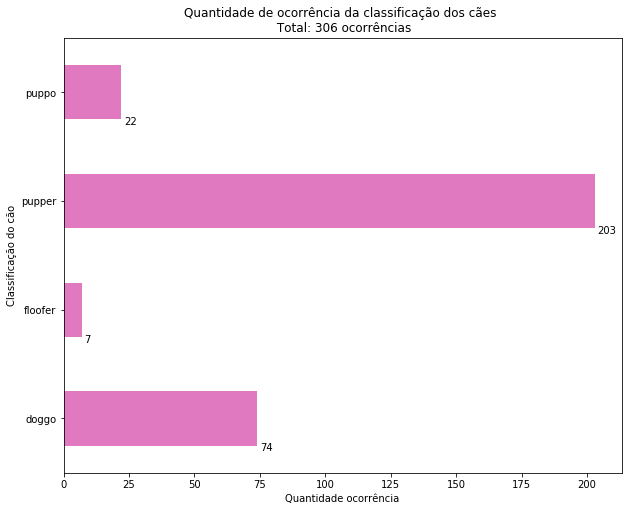

In [79]:
#quantidade de cada classificação dos cães
classificacao = df5.groupby('stage')['qtde'].sum().plot(kind='barh', figsize=(10,8), color=random.choice(colors))

# coloca a quantidade nas barras
for c in classificacao.patches:
    b=c.get_bbox()
    classificacao.annotate("{:.0f}".format(b.x1 + b.x0), (c.get_x() + c.get_width() + 1, c.get_y() - 0.05))
    
plt.title('Quantidade de ocorrência da classificação dos cães \n Total: '+ str(df5['qtde'].sum())+ ' ocorrências')
plt.xlabel('Quantidade ocorrência')
plt.ylabel('Classificação do cão')
plt.show()